# Clase 05a: Filtrado Espacial

## Objetivos de esta Clase:

En esta primera parte nos dedicaremos a practicar algunas operaciones de filtrado espacial que pueden considerarse en una etapa de post-clasificación, pero que también son válidas en cualquier etapa del procesamiento o pre-procesamiento de nuestras imágenes. Luego pasaremos a vector nuestra matriz filtrada, y la usaremos como entrada para algunos geoprocesos que aprenderemos en la Clase05b (la siguiente Notebook). Los objetivos que se esperan cubrir luego de finalizar esta clase son:

1) Aprender a realizar operaciones de filtros lineales (convolución) y no lineales sobre archivos raster.  
2) Aprender cómo convertir del formato raster al vectorial.  
3) Implementar geoprocesos y/o operaciones de análisis vectorial con Python

## 1. Filtros lineales (convolucionales)

El primer tema que abordaremos es el de filtrado espacial de un raster. Los filtros lineales implican operaciones de [convolución](https://es.wikipedia.org/wiki/Convoluci%C3%B3n) donde se aplica un operador o una función a los píxeles de la imagen por medio de algo que se conoce como ventana móvil o _kernel_. Esta ventana o kernel puede ser de distintas dimensiones, pero generalmente se usan matrices de tipo cuadradas (3x3, 5x5, etc.) donde sus celdas poseen coeficientes en función de la operación a realizar. La misma es _movil_ en el sentido de que el filtro va desplazando la ventana a lo largo de la imagen para operar con los píxeles y así obtener un nuevo valor, tal como ilustra el siguiente GIF:  

<!-- ![kernel.gif](attachment:kernel.gif) -->

<p align="left">
 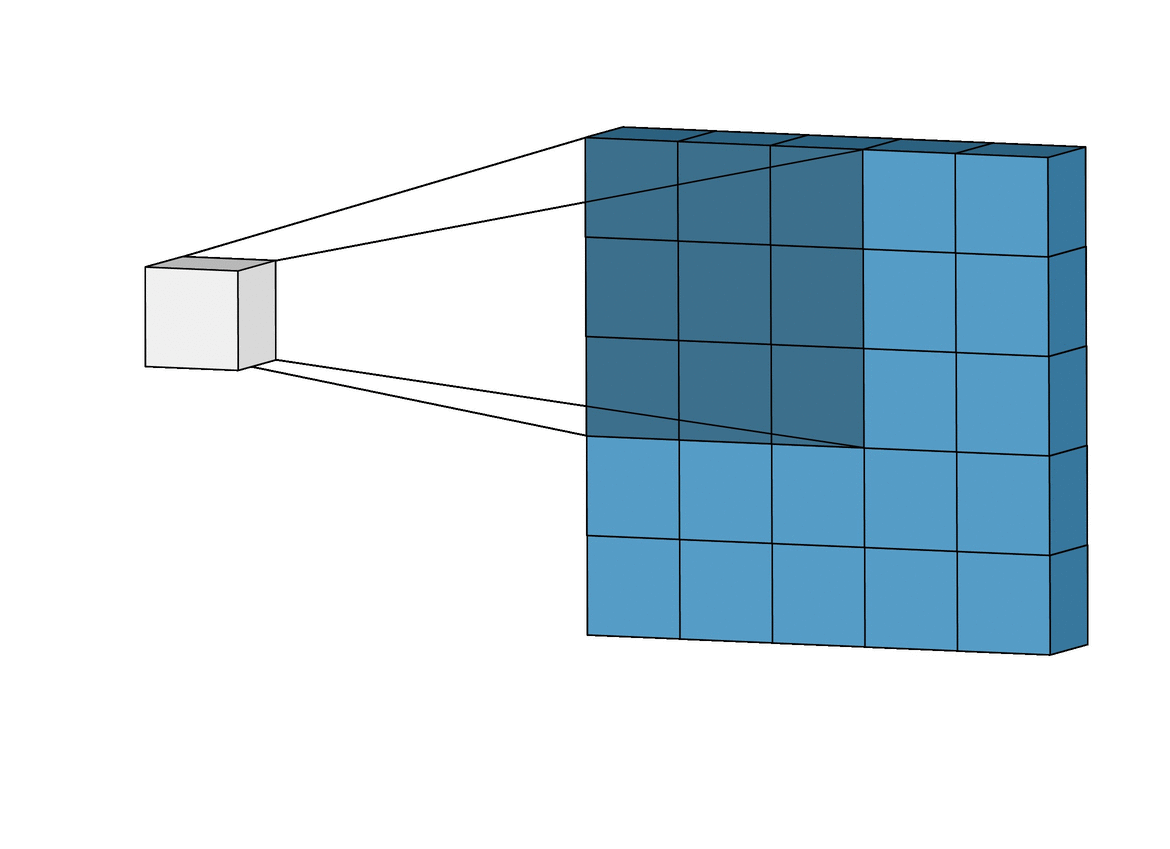
</p>

Existe una gran diversidad de filtros lineales según el objetivo que se persiga: Una manera habitual de dividirlos es clasificarlos como filtrado de paso bajo y paso alto, que sirven para suavizar o realzar una imagen respectivamente. En otra sección de esta Notebook nos ocuparemos especialmente de algunos filtros no lineales como los filtros de moda o de mediana.

### 1.1. Kernel o ventana movil

El kernel es una matriz "pequeña" (en relación a la imagen entera) a la que vamos desplazando a lo largo de la imagen en la opeación de convolución. Este kernel contiene en cada una de sus celdas números que al ser multiplicados por las celdas de la imagen producen un resultado determinado. Generalmente, desplazamos el kernel de izquierda a derecha, y de arriba hacia abajo:

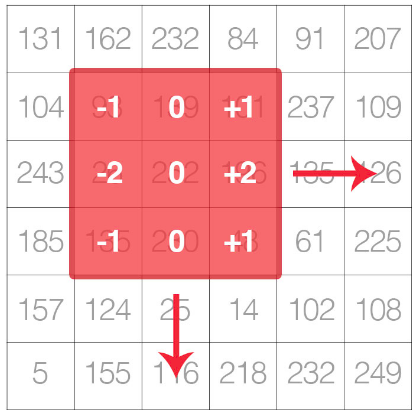

De esta manera, a medida que nos movemos el kernel define una **vecindad** de píxeles alrededor del centro de la ventana móvil, y se hace la convolución entre los píxeles de esa vecindad y cada elemento del kernel.

Los kernel generalmente son matrices cuadradas de números impares  (3x3, 5x5, 7x7, etc), aunque también pueden definirse ventanas no necesariamente cuadradas. Lo que no es habitual, es usar ventanas o kernel de dimensiones pares (2x2, 4x4, 6x6, etc); ¿se les ocurre por qué? El siguiente es un ejemplo de kernel muy simple para hacer el filtro de media de 3x3, que se usa para suavizar las imágenes:

<div align="left">
$$
K = \frac{1}{9} \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$
</div>


Para un pixel con coordenadas _[i,j]_ , se posiciona el centro del kernel en esas coordenadas. Luego se multiplica cada elemento del kernel por su correspondiente pixel en la imagen, y los resultados de cada multplicación se van sumando. El valor del pixel _filtrado_ es el resultado de estas operaciones:

$$
O_{i,j} = \frac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\star
\begin{bmatrix}
197 & 50 & 213 \\
3 & 181 & 203 \\
231 & 2 & 93
\end{bmatrix}
=
\begin{bmatrix}
\frac{1}{9} \times 197 & \frac{1}{9} \times 50 & \frac{1}{9} \times 213 \\
\frac{1}{9} \times 3 & \frac{1}{9} \times 181 & \frac{1}{9} \times 203 \\
\frac{1}{9} \times 231 & \frac{1}{9} \times 2 & \frac{1}{9} \times 93
\end{bmatrix}
$$




### 1.2. El problema de los bordes

Existe una cuestión no menor y es cuando nos encontramos en los bordes de la imagen. En estas posiciones no es factible "centrar" el kernel, porque los píxeles de borde nunca pueden ser centro de una ventana cuadrada o rectangular (ya que más allá de ellos no hay datos). El resultado _por defecto_ es que la convolución como la venimos presentando necesariamente produce una matriz más pequeña que la original, como muestra la siguiente ilustración:

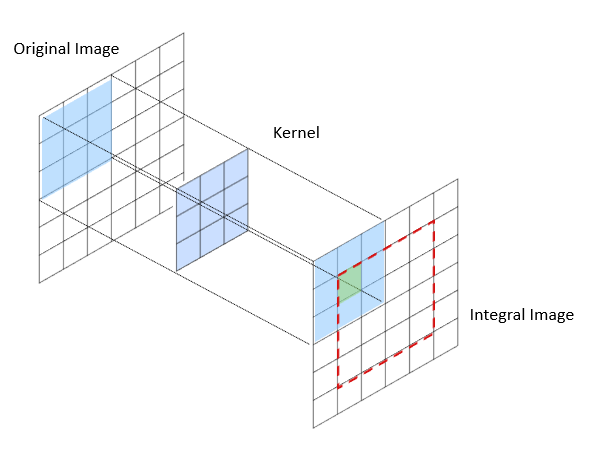

En la práctica, se pueden rellenar píxeles de borde, algo que en inglés se conoce como _padding_. Este relleno se hace con de acuerdo a determinado criterio, principalmente en cuanto a  las dimensiones de la matriz de salida, y también en cuanto modo de rellenar los píxeles que quedan vacíos en la misma.

#### Dimensiones de la imagen de salida

Cuando aplicamos una convolución, se puede optar por tres criterios distintos en cuanto al tamaño de la imagen de salida:

- **Válido o _valid_**: No se rellenan píxeles hacia afuera, con lo cual la matriz resultante es más pequeña que la imagen de entrada:

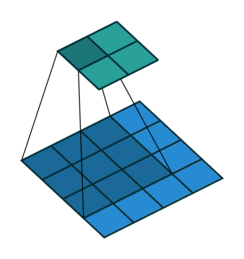

- **Igual o _same_**: En este caso la matriz de salida tiene el mismo tamaño que la imagen de entrada. Solo se rellena una fila hacia afuera, correspondiente a los píxeles de borde:

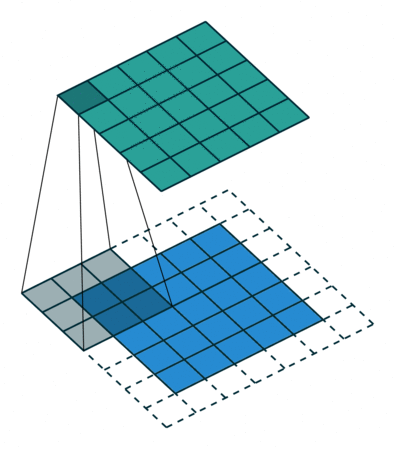

- **Completo o _Full_** : En este caso se hace la convolución total entre el kernel y la imagen. La matriz de salida es más grande que la original. Por ejemplo, con un kernel de 3x3, la salida se expande en 2 filas y 2 columnas:

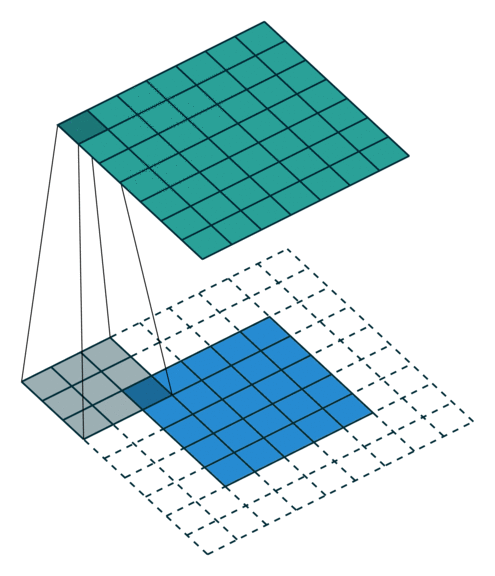

#### Modo de relleno

En los casos donde decidimos hacer _padding_, hay que elegir de qué manera calculamos el valor de esos píxeles que rellenamos. Aquí las soluciones son mucho más variadas, pero generalmente se opta por rellenar con un valor fijo (por ejemplo 0), o simplemente duplicar el valor del pixel vecino.

### 1.3. Filtros de suavizado con Scipy

Habiendo comprendido la lógica detrás de los filtros por convolución, vamos a ver cómo se implementan con algunos ejemplos simples. Utilizaremos para ello la función **convolve2d** de la librería **scipy**. Generalmente, esta librería viene ya con la versión base de Python, o se instala junto a las demás que se requieren para este curso.

Si miramos la [ayuda](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) de esta función en el sitio oficial, veremos que tiene los siguiente parámetros de entrada:

- **In1, In2**: Matrices de entrada (que serán nuestra imagen, y el kernel).
- **Modo**: Qué dimensiones tendrá la imagen de salida. Las opciones son _full_, _valid_ y _same_. La opción por defecto es _full_
- **Bordes (_boundary_)**: Con qué criterio rellenar los bordes, en caso de usar los modos _same_ y _full_. La opción por defecto es rellenarlos con un valor constante (_fill_), que se puede especificar en el parámetro _fillvalue_
- **Fillvalue (valor de relleno)**: Con qué valor rellenar los bordes en caso que en _boundary_ se haya elegido la opción _fill_.

Comencemos entonces por leer nuestra matriz de entrada y armar un kernel. Armaremos uno como en la explicación del texto anterior, para hacer un filtro de media:

#### Filtro de media

Recordemos la formulación del filtro de media, y a continuación un ejemplo de cómo formar un kernel de 3x3:

$$
K = \frac{1}{9} \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$


```python

#Código
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt
import os
import sys
sys.path.append('../')
import funciones as fn


#Creamos una ventana móvil de 3x3
kernel = np.ones((3,3), np.uint8) / 9.

print(kernel)
```

In [1]:
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt
import os

import funciones as fn

kernel = np.ones((3,3), np.uint8) / 9.

print(kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


Vamos a leer alguna de las imágenes que venimos usando, la banda pancromática de la SPOT, para ver el efecto del filtro de media sobre la misma:

```python
spot = gdal.Open('../data/raw_data/SPOT_20170806_PAN.tif')
gt = spot.GetGeoTransform()
src = spot.GetProjection()
spot = spot.ReadAsArray()
```

In [2]:
spot = gdal.Open('./raw_data/SPOT_20170806_PAN.tif')
gt = spot.GetGeoTransform()
src = spot.GetProjection()
spot = spot.ReadAsArray()

Ahora que tenemos la matriz leída y el kernel generado, hacemos la convolución. Usamos el modo _same_ para que la salida tenga las mismas dimensiones que la imagen, y rellenamos los bordes con 0 (opción por defecto):

```python
from scipy import signal
spot_mean_filter_3x3 = signal.convolve2d(spot, kernel, mode = 'same', boundary = 'fill', fillvalue = 0)

print(f'Dimensiones de la matriz original: {spot.shape}')
print(f'Dimensiones de la matriz filtrada: {spot_mean_filter_3x3.shape}')
```

In [3]:
from scipy import signal
spot_mean_filter_3x3 = signal.convolve2d(spot, kernel, mode = 'same', boundary = 'fill', fillvalue = 0)

print(f'Dimensiones de la matriz original: {spot.shape}')
print(f'Dimensiones de la matriz filtrada: {spot_mean_filter_3x3.shape}')

Dimensiones de la matriz original: (3956, 7204)
Dimensiones de la matriz filtrada: (3956, 7204)


Si lo visualizamos maś de cerca, veremos con más claridad los efectos del suavizado:

```python
#Importamos funciones para el ploteo:
import funciones as fn

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot[200:400,600:800],2), cmap = 'gray')
plt.title("Imagen original - Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_mean_filter_3x3[200:400,600:800],2), cmap = 'gray')
plt.title("Imagen con filtro de media 3x3 - Zoom")
plt.show()
```

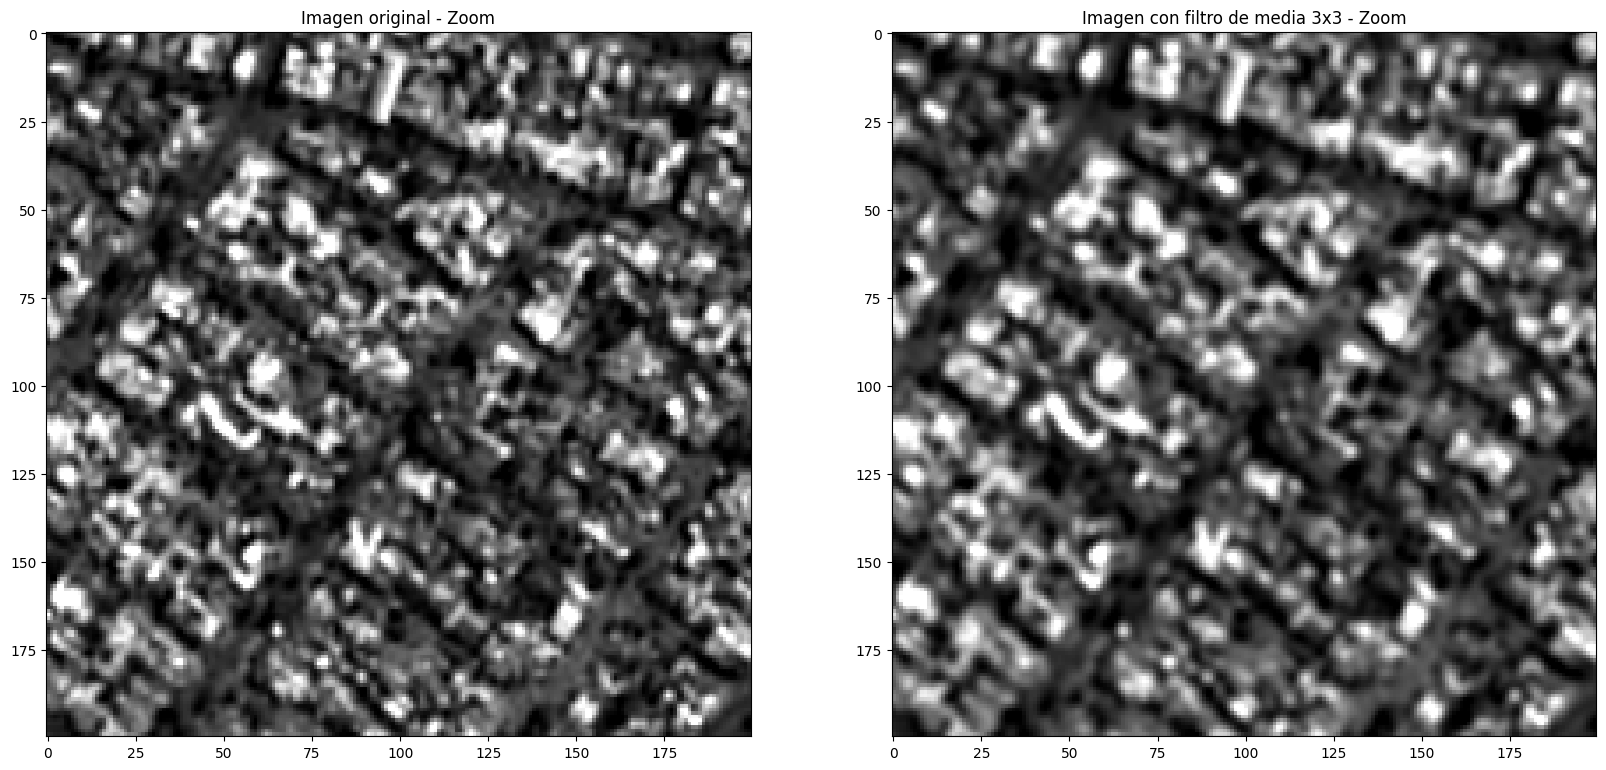

In [4]:
import funciones as fn

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot[200:400,600:800],2), cmap = 'gray')
plt.title("Imagen original - Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_mean_filter_3x3[200:400,600:800],2), cmap = 'gray')
plt.title("Imagen con filtro de media 3x3 - Zoom")
plt.show()

Este suavizado se hace todavía más fuerte si aumentamos el tamaño del kernel:

```python
kernel2 = np.ones((5,5), np.uint8) / 25.
spot_mean_filter_5x5 = signal.convolve2d(spot, kernel2, mode = 'same', boundary = 'fill', fillvalue = 0)


#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot_mean_filter_3x3[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro de media 3x3 - Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_mean_filter_5x5[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro de media 5x5 - Zoom")
plt.show()
```

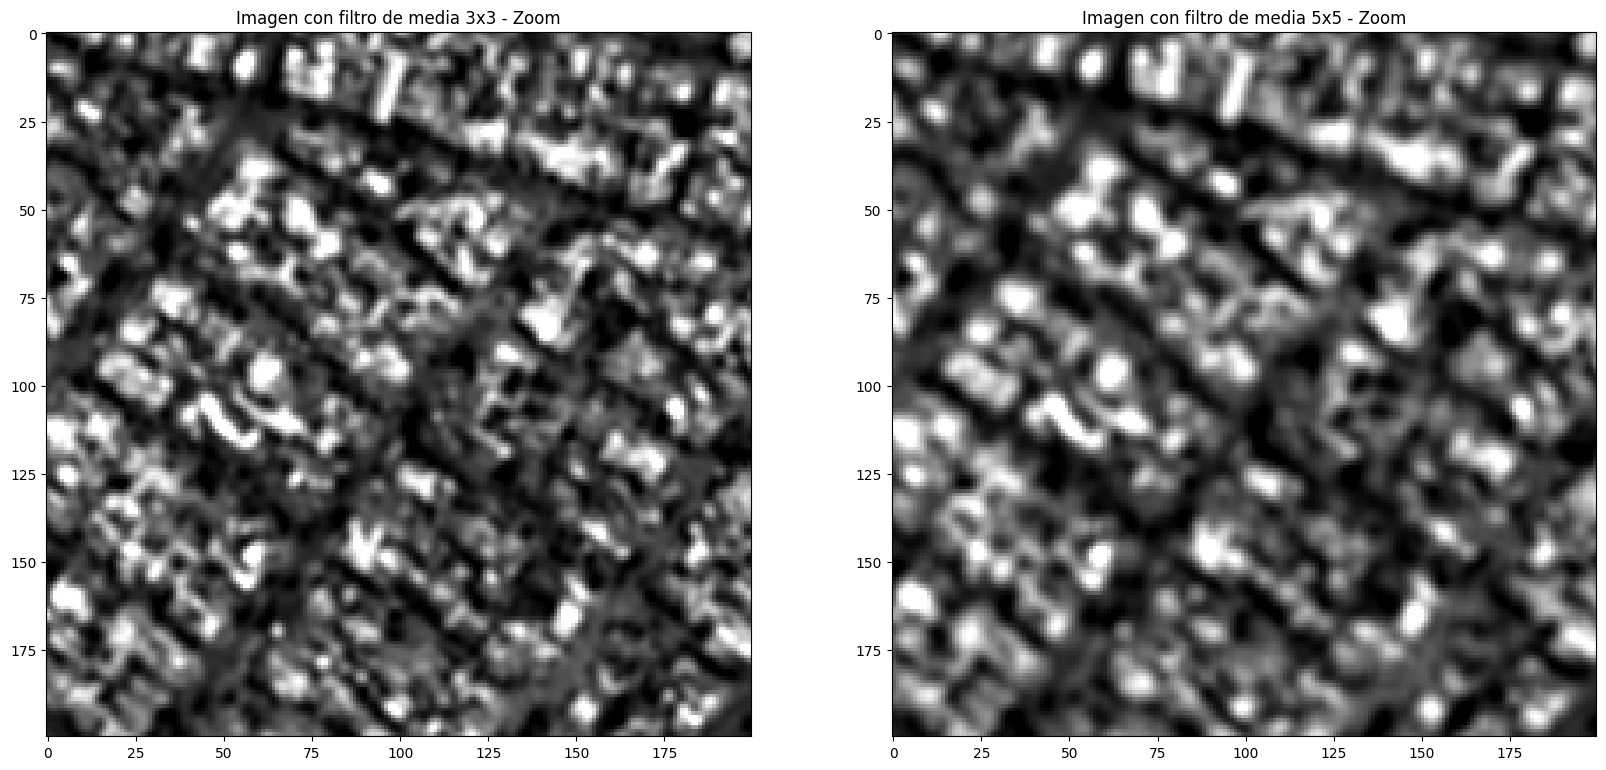

In [5]:
kernel2 = np.ones((5,5), np.uint8) / 25.
spot_mean_filter_5x5 = signal.convolve2d(spot, kernel2, mode = 'same', boundary = 'fill', fillvalue = 0)


#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot_mean_filter_3x3[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro de media 3x3 - Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_mean_filter_5x5[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro de media 5x5 - Zoom")
plt.show()

Está claro que no podemos abusar mucho del tamaño del kernel, porque a medida que más suavizamos, más resolución o dealle espacial estamos perdiendo.

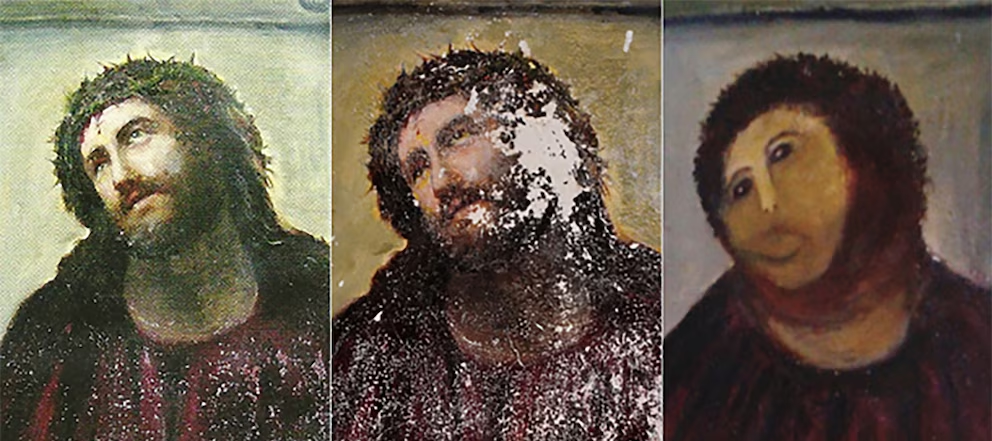

¿Alguien reconoce este cuadro? Link a la [noticia](https://www.bbc.com/mundo/noticias-62545473). 

#### Filtro gaussiano

Una alternativa al filtro de media para suavizar, es el filtro guassiano. En este caso el kernel toma la forma de una campana gaussiana en 2D, definida según la siguiente fórmula:

$G(x,y) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{x^2 + y^2}{2\sigma^2}}$

Donde $\sigma$ es el desvío estándar de la distribución, que si tiene una media (centrada en) cero y toma una forma similar a la siguiente figura:

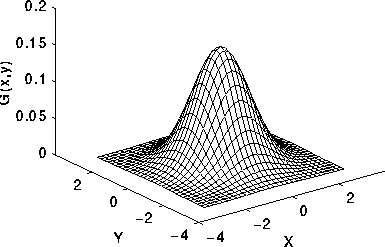

En este tipo de filtrado, mientras más grande el valor del desvío estándar, más fuerte es el efecto del mismo; y el mismo efecto tiene el tamaño del kernel. Funciona de manera muy similar al filtro de media, pero tiende a preservar un poco más los bordes o detalles de los elementos. A continuación, les dejamos una función útil para generar un kernel gaussiano, tomando como entrada las dimensiones del mismo, y su desvío estándar. También cuenta con un parámetro _normalized_, que si lo seteamos como **True** fuerza que el volumen de la campana sea siempre 1:

```python
def gaussian_kernel(n, m, std):
    '''
    Generates an n x m Gaussian kernel centered at (0,0),
    using standard deviation `std`. The kernel is normalized
    so that its sum is 1.
    '''
    x = np.linspace(-(n // 2), n // 2, n)
    y = np.linspace(-(m // 2), m // 2, m)
    xx, yy = np.meshgrid(x, y, indexing='ij')

    factor = 1 / (2 * np.pi * std**2)
    kernel = factor * np.exp(-(xx**2 + yy**2) / (2 * std**2))

    return kernel

#Probar un kernel
gauss_kernel = gaussian_kernel(5,5,1)
plt.imshow(gauss_kernel)
```

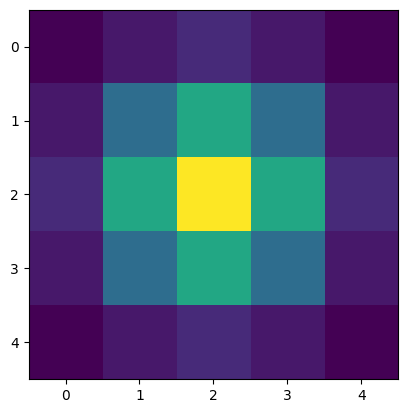

In [6]:
def gaussian_kernel(n, m, std):
    '''
    Generates an n x m Gaussian kernel centered at (0,0),
    using standard deviation `std`. The kernel is normalized
    so that its sum is 1.
    '''
    x = np.linspace(-(n // 2), n // 2, n)
    y = np.linspace(-(m // 2), m // 2, m)
    xx, yy = np.meshgrid(x, y, indexing='ij')

    factor = 1 / (2 * np.pi * std**2)
    kernel = factor * np.exp(-(xx**2 + yy**2) / (2 * std**2))

    return kernel

#Probar un kernel
gauss_kernel = gaussian_kernel(5,5,1)
plt.imshow(gauss_kernel)

Probemos el kernel gaussiano y hagamos la comparación con el filtro de media:

```python
spot_gauss_filter_5x5 = signal.convolve2d(spot, gauss_kernel, mode = 'same', boundary = 'fill', fillvalue = 0)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot_mean_filter_5x5[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro de media 5x5 - Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_gauss_filter_5x5[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro gaussiano 5x5 - Zoom")
plt.show()
```

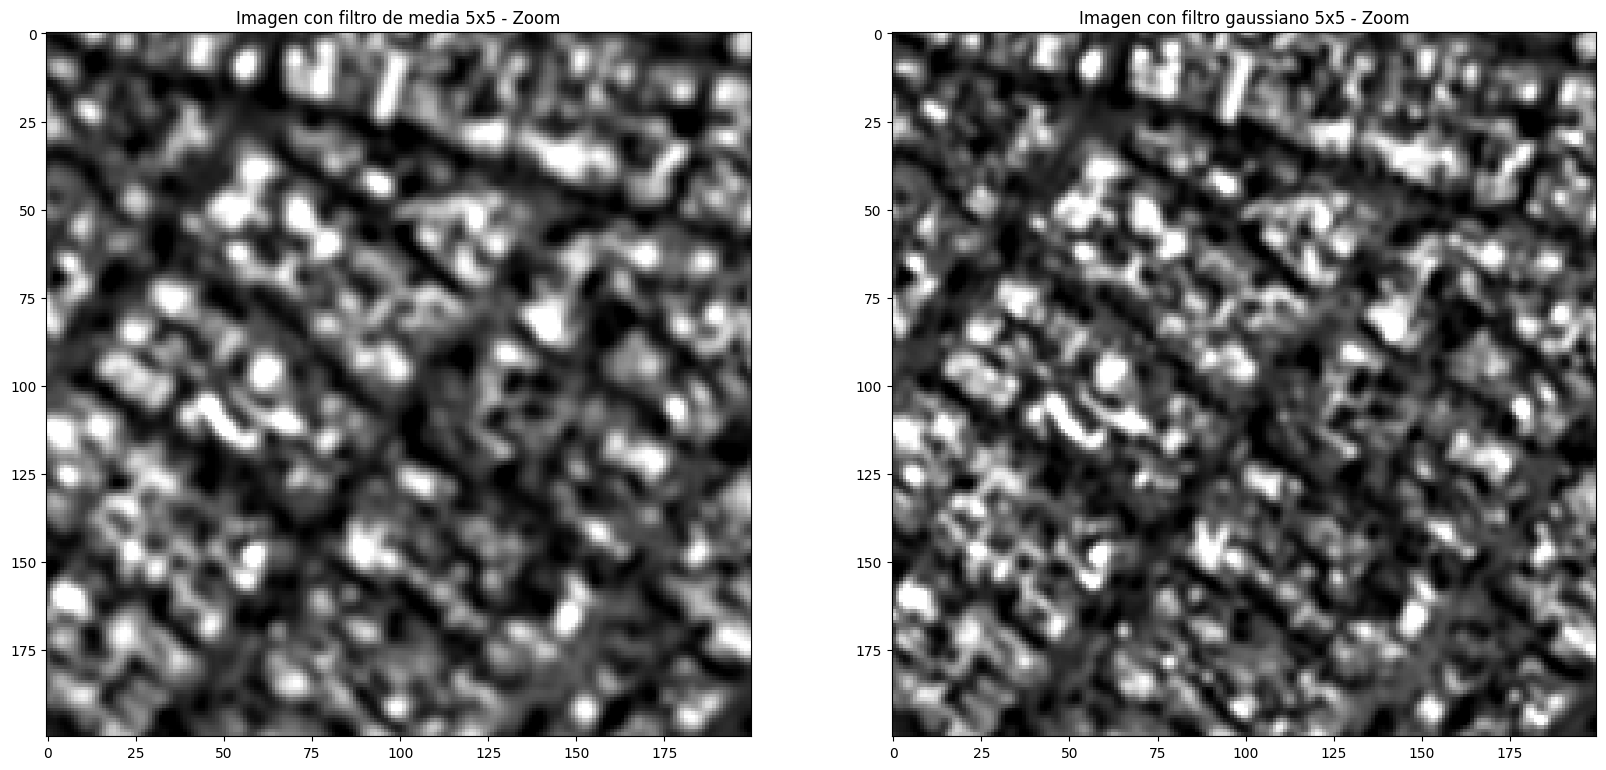

In [7]:
spot_gauss_filter_5x5 = signal.convolve2d(spot, gauss_kernel, mode = 'same', boundary = 'fill', fillvalue = 0)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot_mean_filter_5x5[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro de media 5x5 - Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_gauss_filter_5x5[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro gaussiano 5x5 - Zoom")
plt.show()

### 1.4. Filtros de realce o paso alto:

Al contrario de los filtros de paso bajo, nos puede interesar realzar los elementos o ciertas características de la imagen. En ese caso, definimos un kernel distinto. Veamos el efecto de este filtro sobre nuestra SPOT:

$$
K = \frac{1}{9}
\begin{bmatrix}
-1 & -1 & -1 \\
-1 &  1 & -1 \\
-1 & -1 & -1
\end{bmatrix}
$$


```python
kernel_hp = (np.ones((3,3))*-1) / 9.
kernel_hp[1,1] = 1

print(kernel_hp)

spot_hp_filter_3x3 = signal.convolve2d(spot, kernel_hp, mode = 'same', boundary = 'fill', fillvalue = 0)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot[200:400,600:800],2), cmap='gray')
plt.title("Imagen original- Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_hp_filter_3x3[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro paso alto 3x3 - Zoom")
plt.show()
```

[[-0.11111111 -0.11111111 -0.11111111]
 [-0.11111111  1.         -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111]]


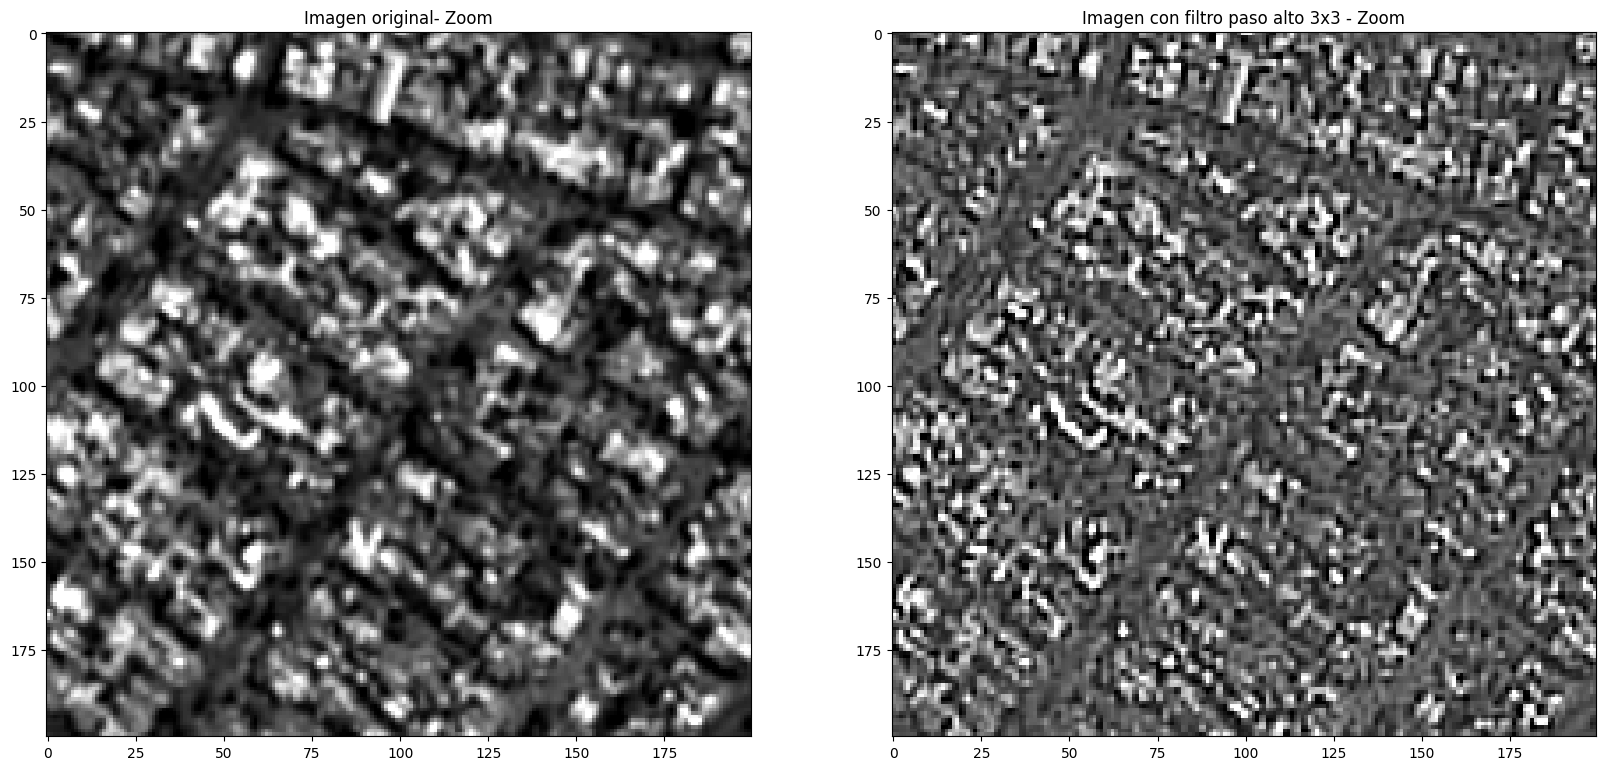

In [8]:
kernel_hp = (np.ones((3,3))*-1) / 9.
kernel_hp[1,1] = 1

print(kernel_hp)

spot_hp_filter_3x3 = signal.convolve2d(spot, kernel_hp, mode = 'same', boundary = 'fill', fillvalue = 0)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(fn.scale(spot[200:400,600:800],2), cmap='gray')
plt.title("Imagen original- Zoom")
plt.subplot(1,2,2)
plt.imshow(fn.scale(spot_hp_filter_3x3[200:400,600:800],2), cmap='gray')
plt.title("Imagen con filtro paso alto 3x3 - Zoom")
plt.show()

Podemos guardar estos resultados para visualizarlos en QGIS u otro software:

```python
fn.write_raster_gdal(spot_hp_filter_3x3, '../data/proc', 'paso_alto.tif', 'GTiff', gdal.GDT_Float32, gt, src )
fn.write_raster_gdal(spot_gauss_filter_5x5, '../data/proc', 'gaussiana.tif', 'GTiff', gdal.GDT_Float32, gt, src )
```

In [9]:
fn.write_raster_gdal(spot_hp_filter_3x3, './proc', 'paso_alto.tif', 'GTiff', gdal.GDT_Float32, gt, src )
fn.write_raster_gdal(spot_gauss_filter_5x5, './proc', 'gaussiana.tif', 'GTiff', gdal.GDT_Float32, gt, src )

Este tipo de filtrados se suele usar para detectar bordes de los objetos, e incluso para resaltar características en una dirección determinada. ¿Se les ocurre cómo puede ser un kernel para resaltar los objetos en el sentido horizontal o vertical, por ejemplo?

## 2. Filtros no lineales

En los filtros por convolución que presentamos anteriormente se podía pensar a la salida o resultado como una función o combinación lineal de la matriz de entrada y los operadores definidos por el _kernel_.

En los filtros no lineales esto no necesariamente es así. Muchas veces son de gran utilidad para determinadas componentes de ruido puntuales y preservar el resto de los elementos como están. De hecho, para "limpiar" un raster con valores discreto como las clasificaciones seguramente sean más adecuados. 

Al igual que en el filtrado por convolución, se utiliza un kernel o elemento estructurante que se va moviendo por la imagen, pero esta vez no para operar pixel a pixel, sino para evaluar alguna condición (por ejemplo, el valor máximo, el mínimo, la mediana) y en base a ello producir un resultado. Los filtros no lineales que presentaremos aqúi son: el filtro de moda y el de mediana.

En esta Notebook utilizaremos este tipo de filtros para intentar simplificar la estructura y variabilidad de nuestros archivos raster, y usaremos la salida de alguno de ellos para pasar la clasificación a vector en la sección 3.

La aplicación de estos filtros tiene más sentido sobre imágenes binarias (por ejemplo, un umbralizado sobre un NDVI), o con niveles de grises discretos, como una clasificación. Trabajaremos con un raster que se llama **Class_IMG_RF.tif**, que es el resultado de una clasificación similar a las que obtendrán en las clases 6 y 7.

```python
clasif = gdal.Open('../data/raw_data/Class_IMG_RF.tif')

#Por las dudas, guardo el GeoTransform() y el SRC:

gt_clasif = clasif.GetGeoTransform()
src_clasif = clasif.GetProjection()
clasif = clasif.ReadAsArray()
```

In [10]:
clasif = gdal.Open('./raw_data/Class_IMG_RF.tif')

#Por las dudas, guardo el GeoTransform() y el SRC:

gt_clasif = clasif.GetGeoTransform()
src_clasif = clasif.GetProjection()
clasif = clasif.ReadAsArray()

En esta clasificación tenemos:

- Agua: Píxeles con valor 0
- Bosque: Píxeles con valor 1
- Humedal: Píxeles con valor 2
- Rural: Píxeles con valor 3
- Urbano: Píxeles con valor 4

```python
print('Valores de clases dentro del array: ',np.unique(clasif))
```

In [11]:
print('Valores de clases dentro del array: ',np.unique(clasif))

Valores de clases dentro del array:  [0. 1. 2. 3. 4.]


### 2.1. Filtro de moda

El filtro de moda es un ejemplo de la categoría No-Lineal. En estos casos el valor del pixel resultante corresponde al valor más frecuente (moda) encontrado dentro de sus píxeles vecinos. Ppodemos aplicarlo usando Scipy, pero a diferencia de otros filtros, no hay un método que lo implemente directamente, con lo cual les facilitamos una función llamada **calc_mode()** para hacer el cálculo de la moda. Luego, llamamos a esta función dentro del método **generic_filter** de Scipy. 

El problema de este método es que al ejecutarse por cada vez que vamos moviendo el kernel o ventana móvil, puede terminar siendo **muy lento**:

```python
from scipy.ndimage import generic_filter
from time import time

def calc_mode(window):
    values, counts = np.unique(window, return_counts=True)
    return values[np.argmax(counts)]

a = time()
clasif_mode = generic_filter(clasif, calc_mode, size=3)
b = time()

print(f'Tiempo de ejecución: {(b - a):.2f} segundos')

# Visualización
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(clasif[200:400,600:800])
plt.title("Imagen original")
plt.subplot(1,2,2)
plt.imshow(clasif_mode[200:400,600:800])
plt.title("Filtro de moda 3x3")
plt.show()

Tiempo de ejecución: 12.30 segundos


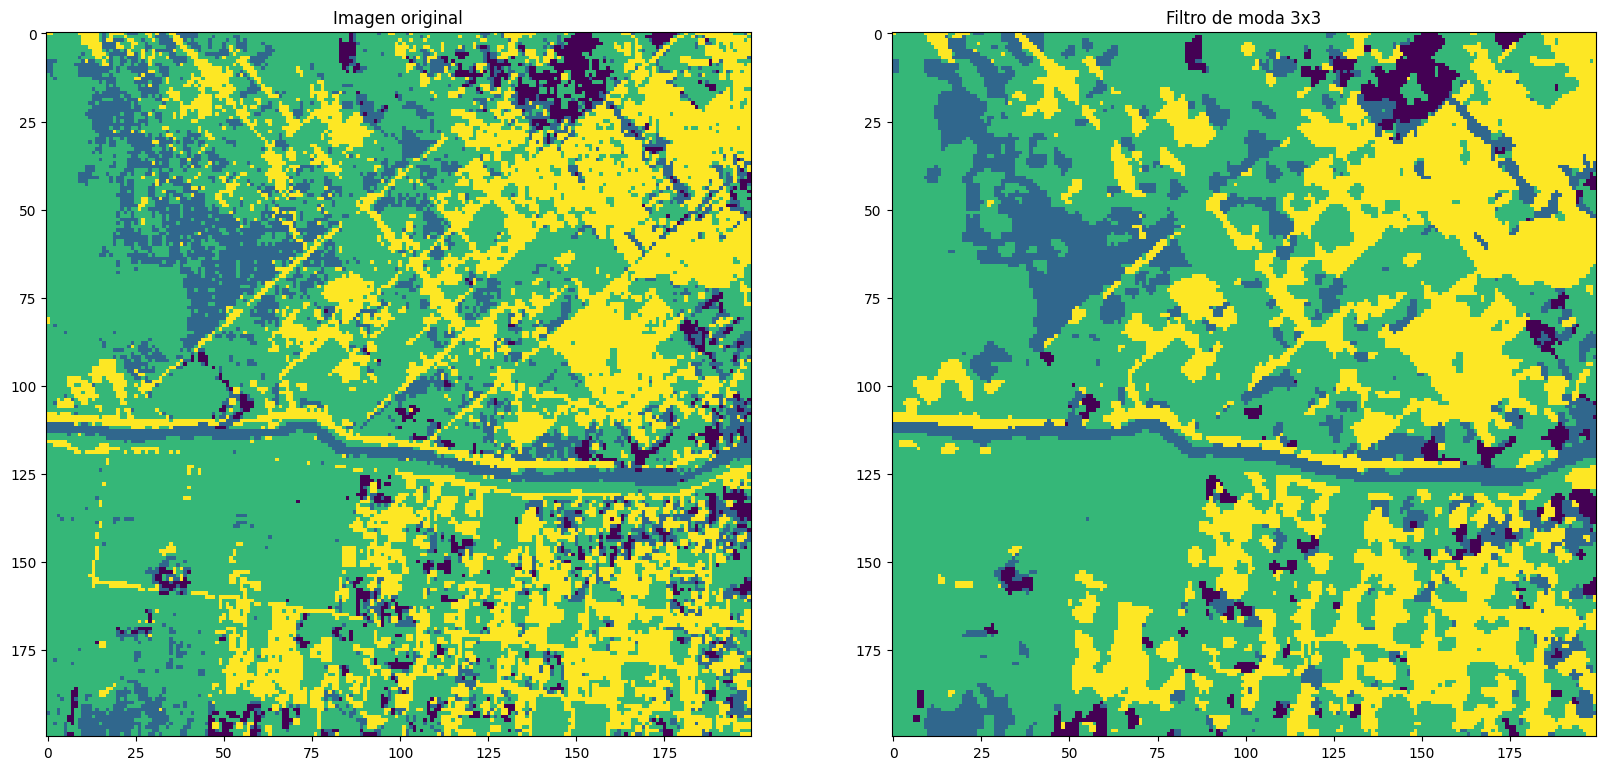

In [12]:
from scipy.ndimage import generic_filter
from time import time

def calc_mode(window):
    values, counts = np.unique(window, return_counts=True)
    return values[np.argmax(counts)]

a = time()
clasif_mode = generic_filter(clasif, calc_mode, size=3)
b = time()

print(f'Tiempo de ejecución: {(b - a):.2f} segundos')

# Visualización
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(clasif[200:400,600:800])
plt.title("Imagen original")
plt.subplot(1,2,2)
plt.imshow(clasif_mode[200:400,600:800])
plt.title("Filtro de moda 3x3")
plt.show()

Podemos ir guardando nuestras pruebas en **../data/proc** para luego compararlos en QGIS:

```python
fn.write_raster_gdal(clasif_mode,'.','../data/proc/clasif_mode.tif','GTiff',gdal.GDT_Int16, gt_clasif, src_clasif)
```

In [13]:
fn.write_raster_gdal(clasif_mode,'.','./proc/clasif_mode.tif','GTiff',gdal.GDT_Int16, gt_clasif, src_clasif)

### Ejercicio 2.1

a) Probar el filtros de moda distintos tamaños de Kernel. Guardar los resultados de las pruebas en **../data/proc**

In [14]:
clasif = gdal.Open("./raw_data/Class_IMG_RF.tif")

#Por las dudas, guardo el GeoTransform() y el SRC:

gt_clasif = clasif.GetGeoTransform()
src_clasif = clasif.GetProjection()
clasif = clasif.ReadAsArray()

In [16]:
kernel_sizes = [3, 5, 7]
output_dir = "./proc/kernel/"
os.makedirs(output_dir, exist_ok=True)

for k in kernel_sizes:
    print(f"Aplicando filtro de moda con kernel {k}x{k}...")
    a = time()
    result = generic_filter(clasif, calc_mode, size=k)
    b = time()
    print(f"Tiempo: {b - a:.2f} segundos")

    # Guardar GeoTIFF
    output_path = os.path.join(output_dir, f'clasif_mode_{k}x{k}.tif')
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(output_path, clasif.shape[1], clasif.shape[0], 1, gdal.GDT_Byte)
    out_ds.GetRasterBand(1).WriteArray(result)
    out_ds.SetGeoTransform(gt_clasif)
    out_ds.SetProjection(src_clasif)
    out_ds.FlushCache()
    del out_ds

print("¡Todos los archivos guardados correctamente!")

Aplicando filtro de moda con kernel 3x3...
Tiempo: 12.35 segundos
Aplicando filtro de moda con kernel 5x5...
Tiempo: 12.61 segundos
Aplicando filtro de moda con kernel 7x7...
Tiempo: 12.80 segundos
¡Todos los archivos guardados correctamente!


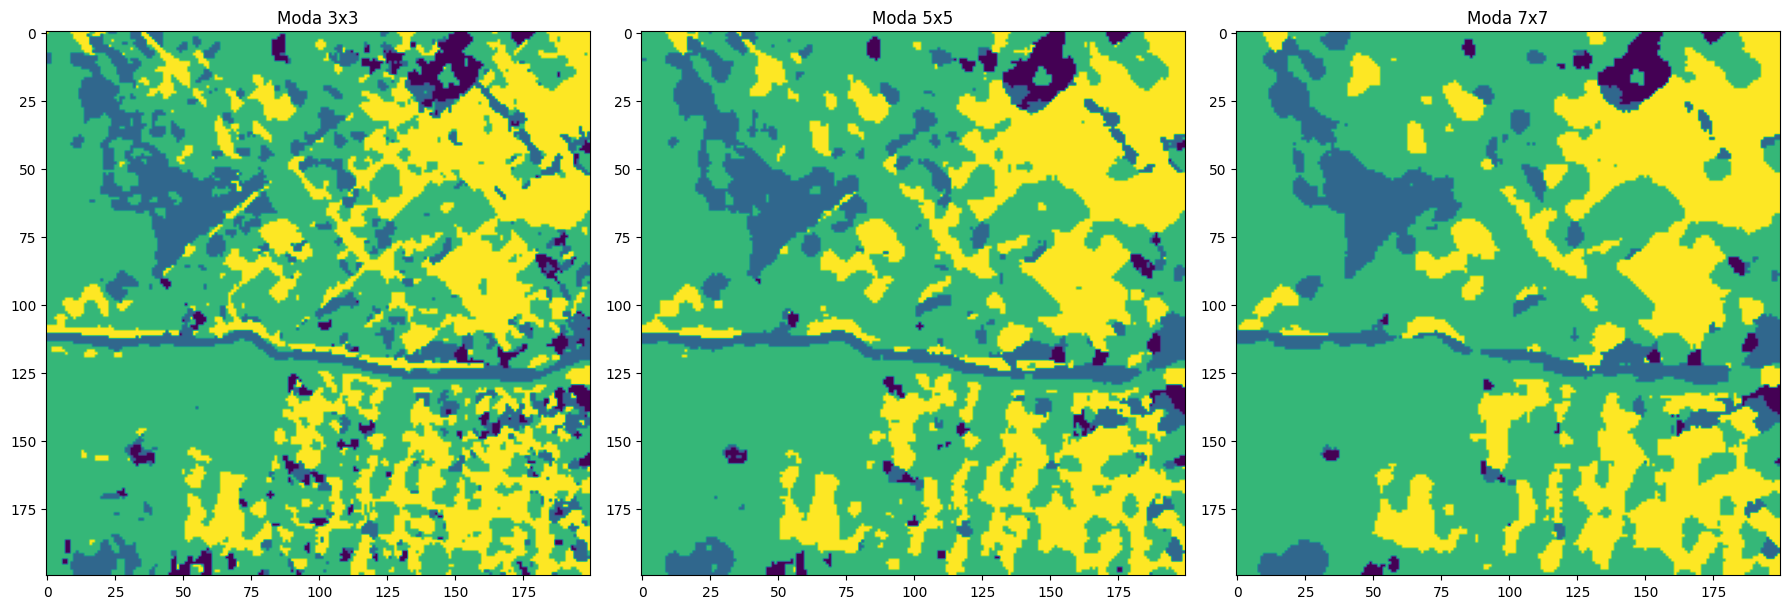

In [18]:
plt.figure(figsize=(18, 6))

for i, k in enumerate(kernel_sizes):
    
    res = gdal.Open(f'./proc/kernel/clasif_mode_{k}x{k}.tif').ReadAsArray()
    
    plt.subplot(1, len(kernel_sizes), i + 1)
    
    plt.imshow(res[200:400, 600:800])
    
    plt.title(f'Moda {k}x{k}')
    
plt.tight_layout()

plt.show()

### 2.2. Filtros morfológicos

Cuando tenemos el resultado de una operación de clasificación o binarización, muchas veces podemos observar "ruidos" o impurezas en los datos,  tales como grupos de píxeles aislados que no tienen mayor relevancia, o incluso “huecos” que pueden no dejarnos del todo cómodos:

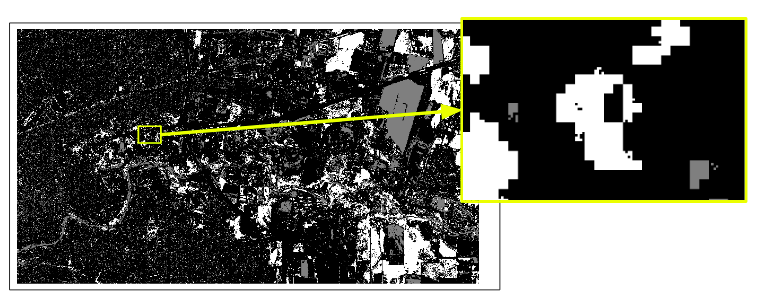

Los filtros morfológicos nos ayudan a limpiar esas impurezas por medio de dos operaciones básicas, conocidas como **erosión** y **dilatación**. Generalmente están pensados para clasificaciones binarias (todo 0 y 1), pero también pueden implementarse en imágenes con distintos niveles de gris. 

**1) Erosión**: En clasificacones binarias tiende a  remover los valores de los píxeles cercanos a los límites de un elemento o forma. Un pixel conserva su valor solo si todos su pixeles vecinos (que entran en la ventana móvil) tienen su mismo valor. De lo contrario, ese pixel pasa a ser 0.

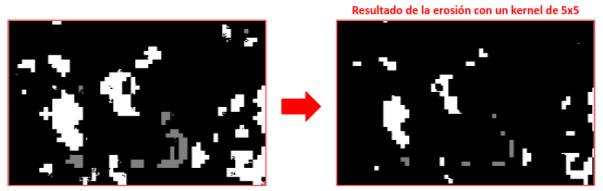

En clasificaciones donde tenemos niveles de gris, el pixel toma el valor **mínimo** de todos sus vecinos, tal como muestra la animación de más abajo:

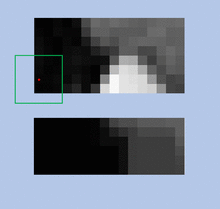

**2) Dilatación**: Es el opuesto a la erosión. Un pixel conserva su valor si cualquiera de sus píxeles vecinos (que entran en la ventana móvil) tienen su mismo valor. De lo contrario, ese pixel pasa a ser 0 (en clasificaciones binarias). En clasificaciones donde tenemos escalas de gris, el pixel toma máximo valor encontrado dentro de la ventana movil que define su vecindad.

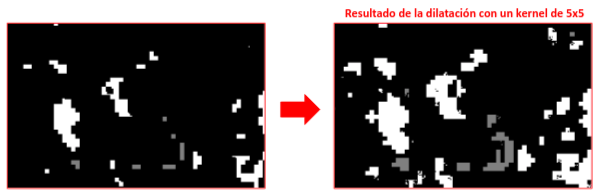

De las dos operaciones básicas se derivan otras como la apertura (opening en inglés), que es equivalente a hacer una erosión seguida de una dilatación; la clausura (closing en inglés) que equivale a hacer una dilatación seguida de una erosión; o el gradiente morfológico, que equivale a hacer la diferencia entre la dilatación y la erosión.

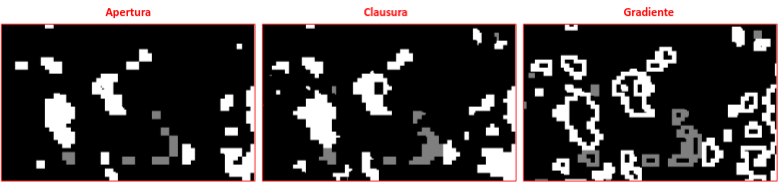

Cuando hagamos este tipo de operaciones morfológicas, debemos tener en cuenta los siguientes parámetros:

- Qué tipo de operación queremos hacer y cuántas veces la queremos repetir  
- En qué secuencia u orden las vamos a hacer (no es lo mismo hacer erosión + dilatación que hacer dilatación + erosión) 
- Qué dimensiones va a tener el kernel o ventana móvil  
- De qué forma va a ser esa ventana móvil (rectangular, en cruz, elíptica, circular??)  

La implementación de estos operadores en python es muy sencilla y está bien [documentada](https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.html). En esta notebook utilizaremos la librería **opencv** para hacer las operaciones, y continuaremos  numpy para crear la ventana móvil o kernel. Veámoslo por ejemplo aplicando la erosión sobre una máscara construida a partir del NDWI que trabajamos en otras clases:

```python
import cv2

#Creamos una ventana móvil de 3x3
kernel = np.ones((3,3), np.uint8)

spot = gdal.Open('../data/raw_data/SPOT_20170806_MS_p.tif')
gt_spot = spot.GetGeoTransform()
src = spot.GetProjection()
spot = spot.ReadAsArray()

#Calculamos el NDWI y creamos una máscara de agua-no agua
ndwi = (spot[1]-spot[3]) / (spot[1]+spot[3])
mascara_ndwi = (ndwi > 0.2)*1

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(ndwi[200:800,1000:1500])
plt.title('NDWI')
plt.subplot(1,2,2)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title('Mascara NDWI > 0.2')
plt.show()
```

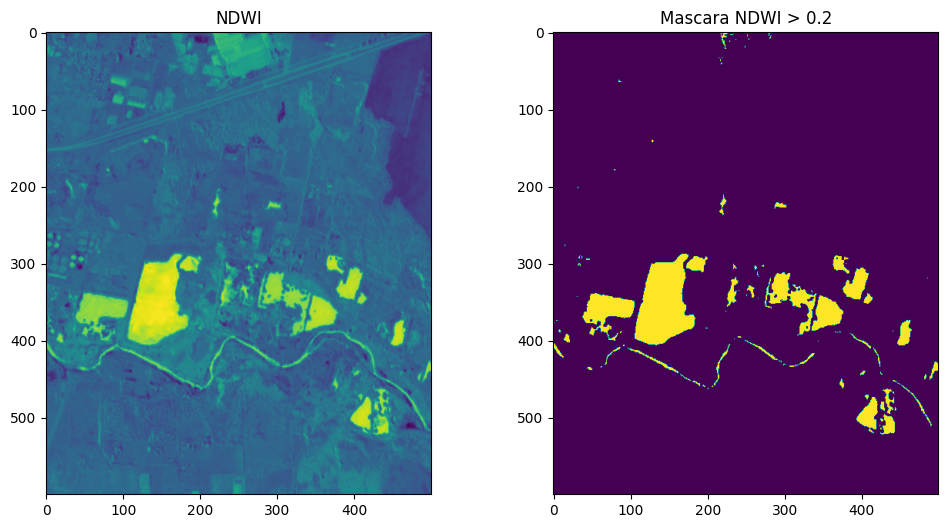

In [20]:
import cv2

#Creamos una ventana móvil de 3x3
kernel = np.ones((3,3), np.uint8)

spot = gdal.Open('./raw_data/SPOT_20170806_MS_p.tif')
gt_spot = spot.GetGeoTransform()
src = spot.GetProjection()
spot = spot.ReadAsArray()

#Calculamos el NDWI y creamos una máscara de agua-no agua
ndwi = (spot[1]-spot[3]) / (spot[1]+spot[3])
mascara_ndwi = (ndwi > 0.2)*1

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(ndwi[200:800,1000:1500])
plt.title('NDWI')
plt.subplot(1,2,2)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title('Mascara NDWI > 0.2')
plt.show()

Probemos el efecto de la erosión sobre esta máscara binaria. Notar que la función _erode_ de _cv2_ necesita que la matriz que le pasamos de entrada sea de tipo flotante:

```python
#Realizamos la erosión:
#Con .astype(float) le pasamos el array como flotante
mascara_erode = cv2.erode(mascara_ndwi.astype(float), kernel, iterations=1)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title("Máscara original - Zoom")
plt.subplot(1,2,2)
plt.imshow(mascara_erode[200:800,1000:1500])
plt.title("Máscara erosionada - Zoom")
plt.show()
```

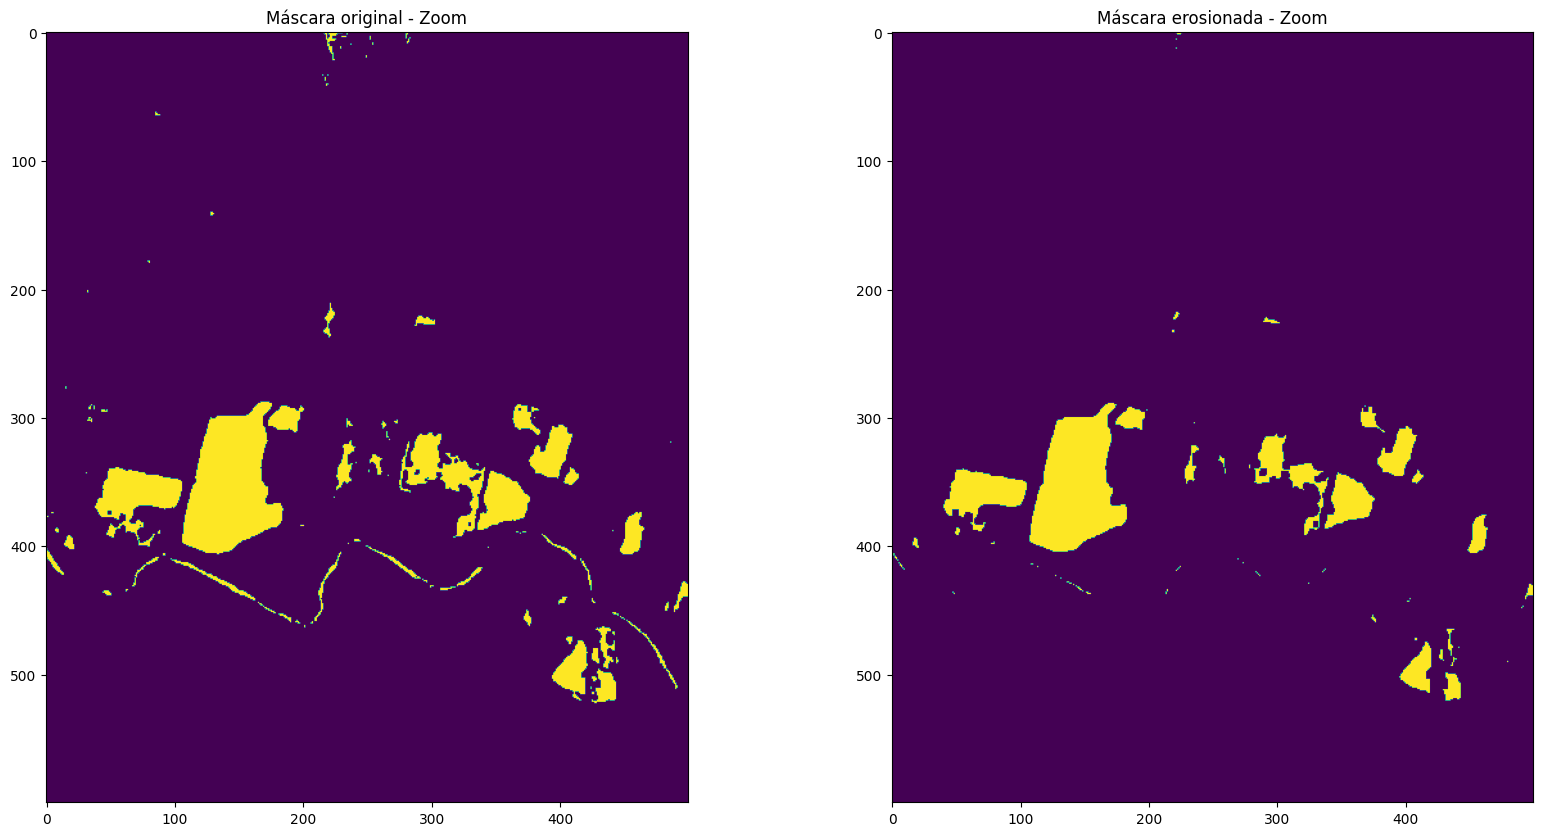

In [21]:
mascara_erode = cv2.erode(mascara_ndwi.astype(float), kernel, iterations=1)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title("Máscara original - Zoom")
plt.subplot(1,2,2)
plt.imshow(mascara_erode[200:800,1000:1500])
plt.title("Máscara erosionada - Zoom")
plt.show()

Veamos como queda con la **dilatación**:

```python
#Realizamos la erosión:
#Con .astype(float) le pasamos el array como flotante
mascara_dilate = cv2.dilate(mascara_ndwi.astype(float), kernel, iterations=1)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title("Máscara original - Zoom")
plt.subplot(1,2,2)
plt.imshow(mascara_dilate[200:800,1000:1500])
plt.title("Máscara dilatada - Zoom")
plt.show()
```

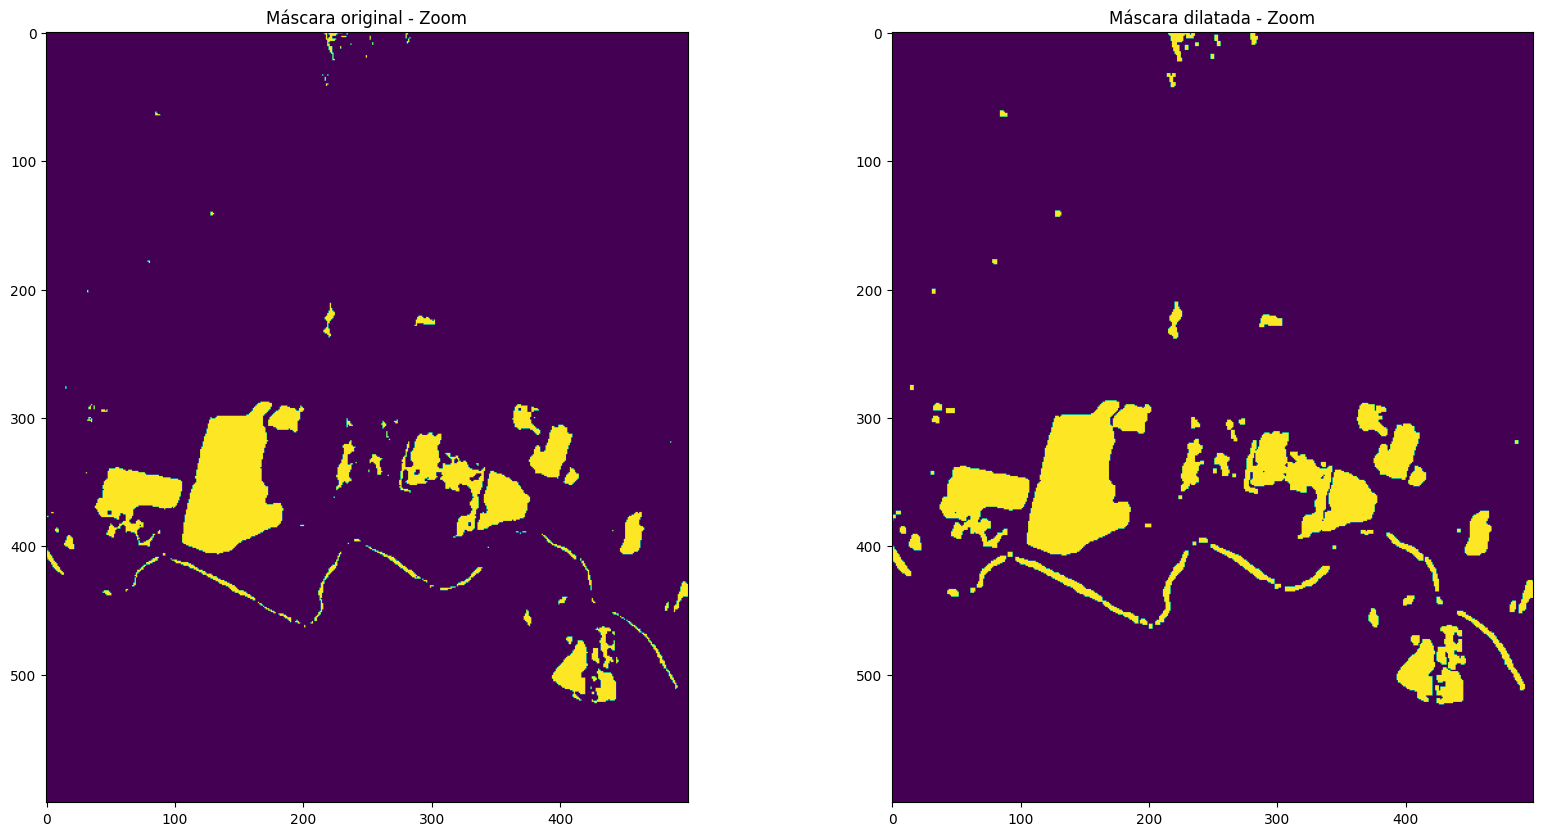

In [22]:
#Realizamos la erosión:
#Con .astype(float) le pasamos el array como flotante
mascara_dilate = cv2.dilate(mascara_ndwi.astype(float), kernel, iterations=1)

#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title("Máscara original - Zoom")
plt.subplot(1,2,2)
plt.imshow(mascara_dilate[200:800,1000:1500])
plt.title("Máscara dilatada - Zoom")
plt.show()

Con las funciones que aprendimos en las clases 3 o 4, las podemos guardar rápidamente como GeoTiff para visualizarlas en QGIS:

```python
fn.write_raster_gdal(mascara_erode,'.','../data/proc/mascara_erode.tif','GTiff',gdal.GDT_Int16, gt_spot, src)
fn.write_raster_gdal(mascara_dilate,'.','../data/proc/mascara_dilate.tif','GTiff',gdal.GDT_Int16, gt_spot, src)
fn.write_raster_gdal(mascara_ndwi,'.','../data/proc/mascara_orig.tif','GTiff',gdal.GDT_Int16, gt_spot, src)
```

In [23]:
fn.write_raster_gdal(mascara_erode,'.','./proc/mascara_erode.tif','GTiff',gdal.GDT_Int16, gt_spot, src)
fn.write_raster_gdal(mascara_dilate,'.','./proc/mascara_dilate.tif','GTiff',gdal.GDT_Int16, gt_spot, src)
fn.write_raster_gdal(mascara_ndwi,'.','./proc/mascara_orig.tif','GTiff',gdal.GDT_Int16, gt_spot, src)

Cuando miremos nuestros resultados en QGIS, probablemente nos demos cuenta que no alcanza con hacer simplemente una erosión o dilatación, sino que hay que recurrir a combinaciones de las mismas. En la celda siguiente se dejan algunos ejemplos, que pueden correr y guardar como archivos al igual que los dos casos anteriores:

```python
#Otras operaciones posibles:

mascara_open = cv2.morphologyEx(mascara_ndwi.astype(float), cv2.MORPH_OPEN, kernel,iterations=1)
mascara_close = cv2.morphologyEx(mascara_ndwi.astype(float), cv2.MORPH_CLOSE, kernel,iterations=1)
mascara_open_close = cv2.morphologyEx(mascara_open, cv2.MORPH_CLOSE, kernel,iterations=1)
mascara_close_open = cv2.morphologyEx(mascara_close, cv2.MORPH_OPEN, kernel,iterations=1)
```

In [24]:
mascara_open = cv2.morphologyEx(mascara_ndwi.astype(float), cv2.MORPH_OPEN, kernel,iterations=1)
mascara_close = cv2.morphologyEx(mascara_ndwi.astype(float), cv2.MORPH_CLOSE, kernel,iterations=1)
mascara_open_close = cv2.morphologyEx(mascara_open, cv2.MORPH_CLOSE, kernel,iterations=1)
mascara_close_open = cv2.morphologyEx(mascara_close, cv2.MORPH_OPEN, kernel,iterations=1)

Visualizamos los resultados:

```python
#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title("Máscara original - Zoom")
plt.subplot(1,2,2)
plt.imshow(mascara_open_close[200:800,1000:1500])
plt.title("Máscara con opening + closing - Zoom")
plt.show()
```

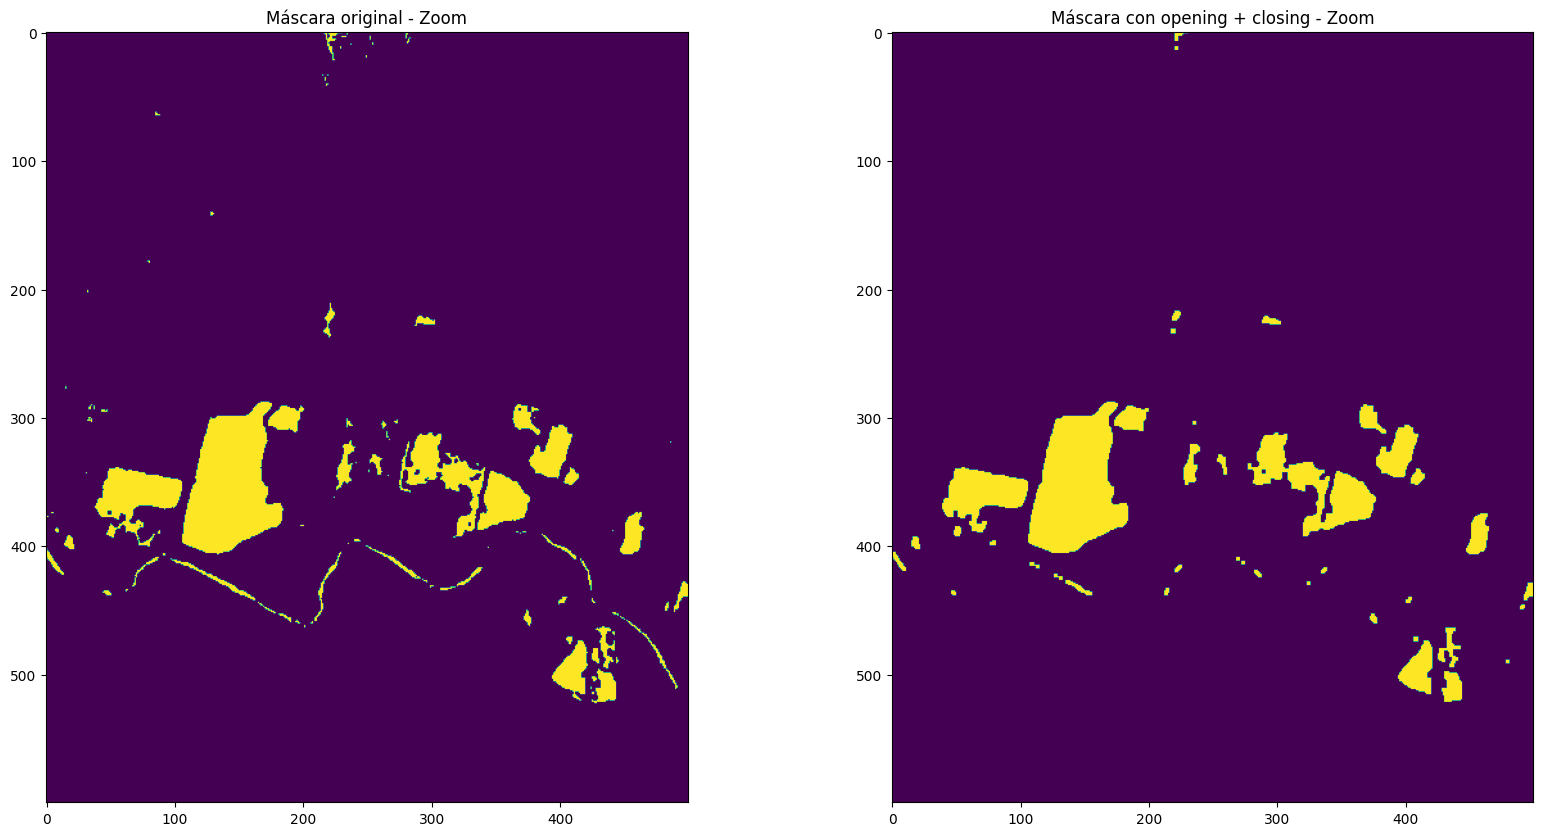

In [25]:
#Visualizamos los resultados:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(mascara_ndwi[200:800,1000:1500])
plt.title("Máscara original - Zoom")
plt.subplot(1,2,2)
plt.imshow(mascara_open_close[200:800,1000:1500])
plt.title("Máscara con opening + closing - Zoom")
plt.show()

## 3. Conversión de  raster a vector

En la próxima Notebook vamos a  hacer un análisis a nivel de radio censal, donde queremos constatar la proporción de área construida que tiene cada radio. Para ello una de las entradas que usaremos será nuestro mapa clasificado, con lo cual necesitaremos convertirlo a vector; y esta será la última actividad que haremos en esta Notebook.

Si bien probamos tanto filtros lineas como no lineales, para el trabajo que sigue vamos a vectorizar solamente alguna de las salidas del filtrado no lineal

### 3.1. Pasando de raster a vector

En entornos SIG es muy frecuente convertir del formato raster a vector (poligonizar) y viceversa (rasterizar). En QGIS por ejemplo esas operaciones se logra con herramientas que están basadas en GDAL. Aquí convertiremos nuestra clasificación a vectores para poder hacer superposiciones con otras capas.

Los filtros realizados en la sección anterior no solo sirvieron para limpiar o pulir la clasificación, sino que hacen más liviana la conversión a formato vectorial desde un raster. La razón es simple: Cada píxel o grupo de píxeles con un valor digital determinado, implica un polígono en la capa de salida luego de la conversión. Esto explica también el por qué elegir la salida del filtrado no lineal para vectorizar.

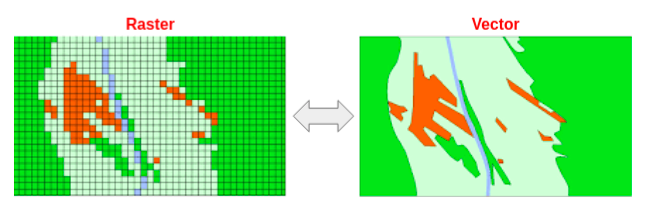

Veamos cómo pasar nuestro raster clasificado a vector con GDAL. Partiremos de alguno de los archivos filtrados en la sección anterior. En esta Notebook trabajamos con el raster resultante de aplicar el filtro de moda (**clasif_mode.tif**).

Existen muchas vías para obtener geometrías a partir de un mapa raster. Dentro de Python podemos probar la función **gdal.Polygonize**, pero cuando se trata de imágenes grandes puede ser extremadamente lenta y muy demandante en uso de memoria.  Nosotros un método alternativo que es interesante por dos motivos: En primer lugar, suele demandar mucho menos recursos y memoria que otros procesos; y en segundo lugar hace uso del método _system_ del módulo de Python **os**, que vale la pena tener en cuenta para otras aplicaciones.

El módulo OS permite al usuario interactuar con el sistema. Se utiliza mucho por ejemplo para el manejo de archivos, carpetas y directorios, como se expone por ejemplo en el [curso de Python](https://github.com/python-unsam/Programacion_en_Python_UNSAM/blob/master/Notas/08_Fechas_Carpetas_y_Pandas/03_Archivos_y_Directorios.md) de la UNSAM.

El método System de OS ejecuta comandos como si estuviéramos parados en una terminal. Es muy útil cuando se necesita llamar desde Python procesos u órdenes que corren solo en ciertos entornos o se encuentran en otro lenguaje como bash de Linux.

Cuando hacemos una conversión de raster a Vector en QGIS, estamos llamando a un programa que se llama **gdal_poligonize**. De hecho, la orden que se escribe se puede ver en el comando de salida al ejecutar la herramienta:

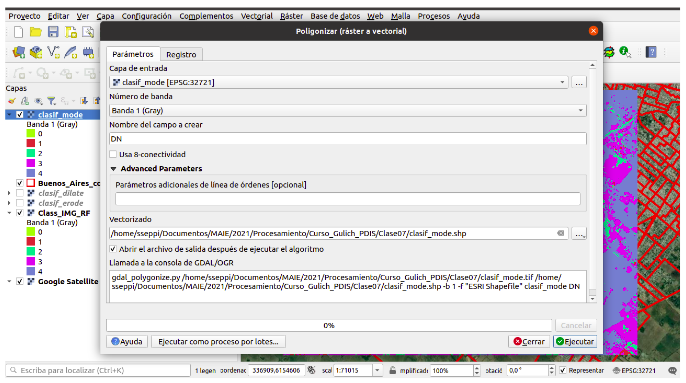

La instrucción anterior toma como entrada el raster **clasif_mode.tif** y genera un archivo shapefile del mismo nombre. A ese archivo shapefile se le crea una columna que se llama **DN**. Esa columna (que podemos nombrar como querramos) es muy importante, porque allí se almacena como atributo el valor digital que tiene cada píxel poligonizado.

Sin embargo, podemos hacer el poligonizado de una manera aún más simple o, mejor dicho, usando herramientas que ya traemos de las clases anteriores, con la librería Geopandas, con Shapely y con Rasterio:

```python
from rasterio.features import shapes
from shapely.geometry import Polygon
from shapely.geometry import shape
import rasterio
import geopandas as gpd

img = rasterio.open('../data/proc/clasif_mode.tif')
metadata = img.meta
geots = metadata['transform']
crs = metadata['crs']

features = list(shapes(clasif_mode, transform=geots))  # Convertir a polígono con la transformación

geom = [shape(x[0]) for x in features]
vals = [x[1] for x in features]

gdf = gpd.GeoDataFrame(vals, columns=['value'], geometry=geom)
gdf.set_crs(crs, inplace=True)
gdf.to_file('../data/proc/salida.gpkg', index=False)
```

In [26]:
from rasterio.features import shapes
from shapely.geometry import Polygon
from shapely.geometry import shape
import rasterio
import geopandas as gpd

img = rasterio.open('./proc/clasif_mode.tif')
metadata = img.meta
geots = metadata['transform']
crs = metadata['crs']

features = list(shapes(clasif_mode, transform=geots))  # Convertir a polígono con la transformación

geom = [shape(x[0]) for x in features]
vals = [x[1] for x in features]

gdf = gpd.GeoDataFrame(vals, columns=['value'], geometry=geom)
gdf.set_crs(crs, inplace=True)
gdf.to_file('./proc/salida.gpkg', index=False)

Si imprimimos la ayuda sobre la función _shapes_ podemos ver más claramenteo que es lo que está haciendo:

```python
help(shapes)
```

In [27]:
help(shapes)

Help on function shapes in module rasterio.features:

shapes(source, mask=None, connectivity=4, transform=Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0))
    Get shapes and values of connected regions in a dataset or array.
    
    Parameters
    ----------
    source : numpy.ndarray, dataset object, Band, or tuple(dataset, bidx)
        Data type must be one of rasterio.int8, rasterio.int16, rasterio.int32,
        rasterio.uint8, rasterio.uint16, rasterio.float32, or rasterio.float64.
    mask : numpy.ndarray or rasterio Band object, optional
        Must evaluate to bool (rasterio.bool_ or rasterio.uint8). Values
        of False or 0 will be excluded from feature generation.  Note
        well that this is the inverse sense from Numpy's, where a mask
        value of True indicates invalid data in an array. If `source` is
        a :class:`numpy.ma.MaskedArray` and `mask` is None, the source's mask will
        be inverted and used in place of `mask`.
    connectivity : int, optional

Dejamos definida una función **raster_to_vector()** que toma un archivo raster de entrada y un nombre de archivo de salida para realizar la conversión de raster a vector. Agregala a tu archivo de funciones, que la volveremos a utilizar:

```python
def raster_to_vector(img_name, output='salida.gpkg'):
    img = rasterio.open(img_name)
    metadata = img.meta
    geots = metadata['transform']
    crs = metadata['crs']
    sds = img.read()
    features = list(shapes(sds, transform=metadata['transform']))
    geom = [shape(feat[0]) for feat in features]
    vals = [feat[1] for feat in features]
    gdf = gpd.GeoDataFrame(vals, columns=['value'], geometry=geom)
    gdf.set_crs(metadata['crs'], inplace=True)
    gdf.to_file(output, index=False)
    
# Celda de prueba
raster_to_vector('../data/proc/clasif_mode.tif', output = '../data/proc/salida2.gpkg')
```

In [29]:
import importlib
import funciones as fn  # o como hayas llamado tu archivo sin el .py
importlib.reload(fn)


fn.raster_to_vector('./proc/clasif_mode.tif', output = './proc/salida2.gpkg')

### Ejercicio 3.1

Modificá la función _raster_to_vector()_ de manera tal que devuelva como variable un _geodataframe_ y que de manera **opcional** te permita guardarlo como un archivo vectorial. Sería algo como lo siguiente:

```python

from rasterio.features import shapes
from shapely.geometry import Polygon
from shapely.geometry import shape
import rasterio
import geopandas as gpd

def raster_to_vector(img_name, value_field = 'value', output = None):
    ...
    ...
    ...
    if output:
        ...
    return gdf

#Probar la función
img_name = '../data/proc/clasif_mode.tif'
vectorizado = raster_to_vector(img_name, value_field = 'value')
```

Guardá tu nueva función en el archivo de funciones

In [30]:
import importlib
import funciones as fn  # o como hayas llamado tu archivo sin el .py
importlib.reload(fn)

<module 'funciones' from 'C:\\Users\\pablonicolasr\\Desktop\\pablonicolas\\educacion_formal\\doctorado_ingenieria_uns\\gulich\\gulich_pdis\\funciones.py'>

In [31]:
img_name = './proc/clasif_mode.tif'
vectorizado = fn.raster_to_vector(img_name, value_field = 'value')